## Geha+25, Figure 2:   Example spectrum and model fit

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

from astropy.table import Table
from astropy.io import ascii,fits
import glob

from dmost.core import  dmost_utils,dmost_flexure, dmost_emcee

import scipy.ndimage as scipynd
from scipy.optimize import curve_fit

DEIMOS_RAW = os.getenv('DEIMOS_RAW')
DEIMOS_REDUX = os.getenv('DEIMOS_REDUX')


In [2]:
plt.rcParams.update({
    "figure.dpi": 200,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "font.size": 17,
    "axes.labelsize": 17,
    "lines.markersize": 5,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 7,
    "xtick.minor.size": 4,
    "ytick.major.size": 7,
    "ytick.minor.size": 4,
    "savefig.bbox": "tight",
    "savefig.dpi": 200,
})

In [3]:
maskname   = 'dra1'
data_dir   = DEIMOS_REDUX+maskname+'/'

nexp = 0
dmost_file  = glob.glob(data_dir+'/dmost/dmost*'+maskname+'.fits')
slits, mask = dmost_utils.read_dmost(dmost_file[0])


In [4]:
# READ SPEC1D FILE
hdu         = fits.open(data_dir+'Science/'+mask['spec1d_filename'][nexp])

file = DEIMOS_REDUX + '/dmost_alldata/dmost_alldata_20250326_Dra.fits'
alldmost = Table.read(file)

In [5]:
tfile    = glob.glob(data_dir+'/dmost/telluric_'+mask['maskname'][nexp]+'_'+mask['fname'][nexp]+'*.fits')
telluric = Table.read(tfile[0])

In [6]:
m=slits['collate1d_SN'] > 50
slits=slits[m]
arg=1

for obj in slits[arg:arg+1]:

    data_wave, data_flux, data_ivar, data_sky = dmost_utils.load_spectrum(obj,nexp,hdu)
    obj['chip_gap_corr'][nexp] = 0.95


In [7]:
sky_file = DEIMOS_RAW+'Other_data/sky_single_mg.dat'
sky=ascii.read(sky_file)
swave = sky['Wave']


In [8]:
plogwave,pflux = dmost_emcee.read_best_template(slits['chi2_tfile'][arg])

# TRIM WAVELENGTH OF TEMPLATES TO SPEED UP COMPUTATION
dmin = np.min(data_wave) - 20
dmax = np.max(data_wave) + 20
mt = (telluric['wave'] > dmin) & (telluric['wave']<dmax)
mp = (plogwave > dmin) & (plogwave<dmax)


# SMOOTH TEMPLATES 
losvd_pix = slits['fit_lsf'][arg,nexp]/ 0.02
sm_pflux  = scipynd.gaussian_filter1d(pflux[mp],losvd_pix,truncate=3)
pwave     = plogwave[mp]

sm_tell   = scipynd.gaussian_filter1d(telluric['flux'][mt],losvd_pix,truncate=3)
twave=telluric['wave'][mt]


v    = slits['emcee_v'][arg,nexp]
w    = slits['emcee_w'][arg,nexp]

npoly=7
pfit = dmost_emcee.get_poly_fit([v, w], data_wave, data_flux, data_ivar, twave,\
                                      sm_tell,sm_pflux,pwave, npoly)

model = dmost_emcee.mk_single_model([v,w], data_wave, data_flux, data_ivar, twave,sm_tell, \
                                    sm_pflux,pwave, npoly,pfit)

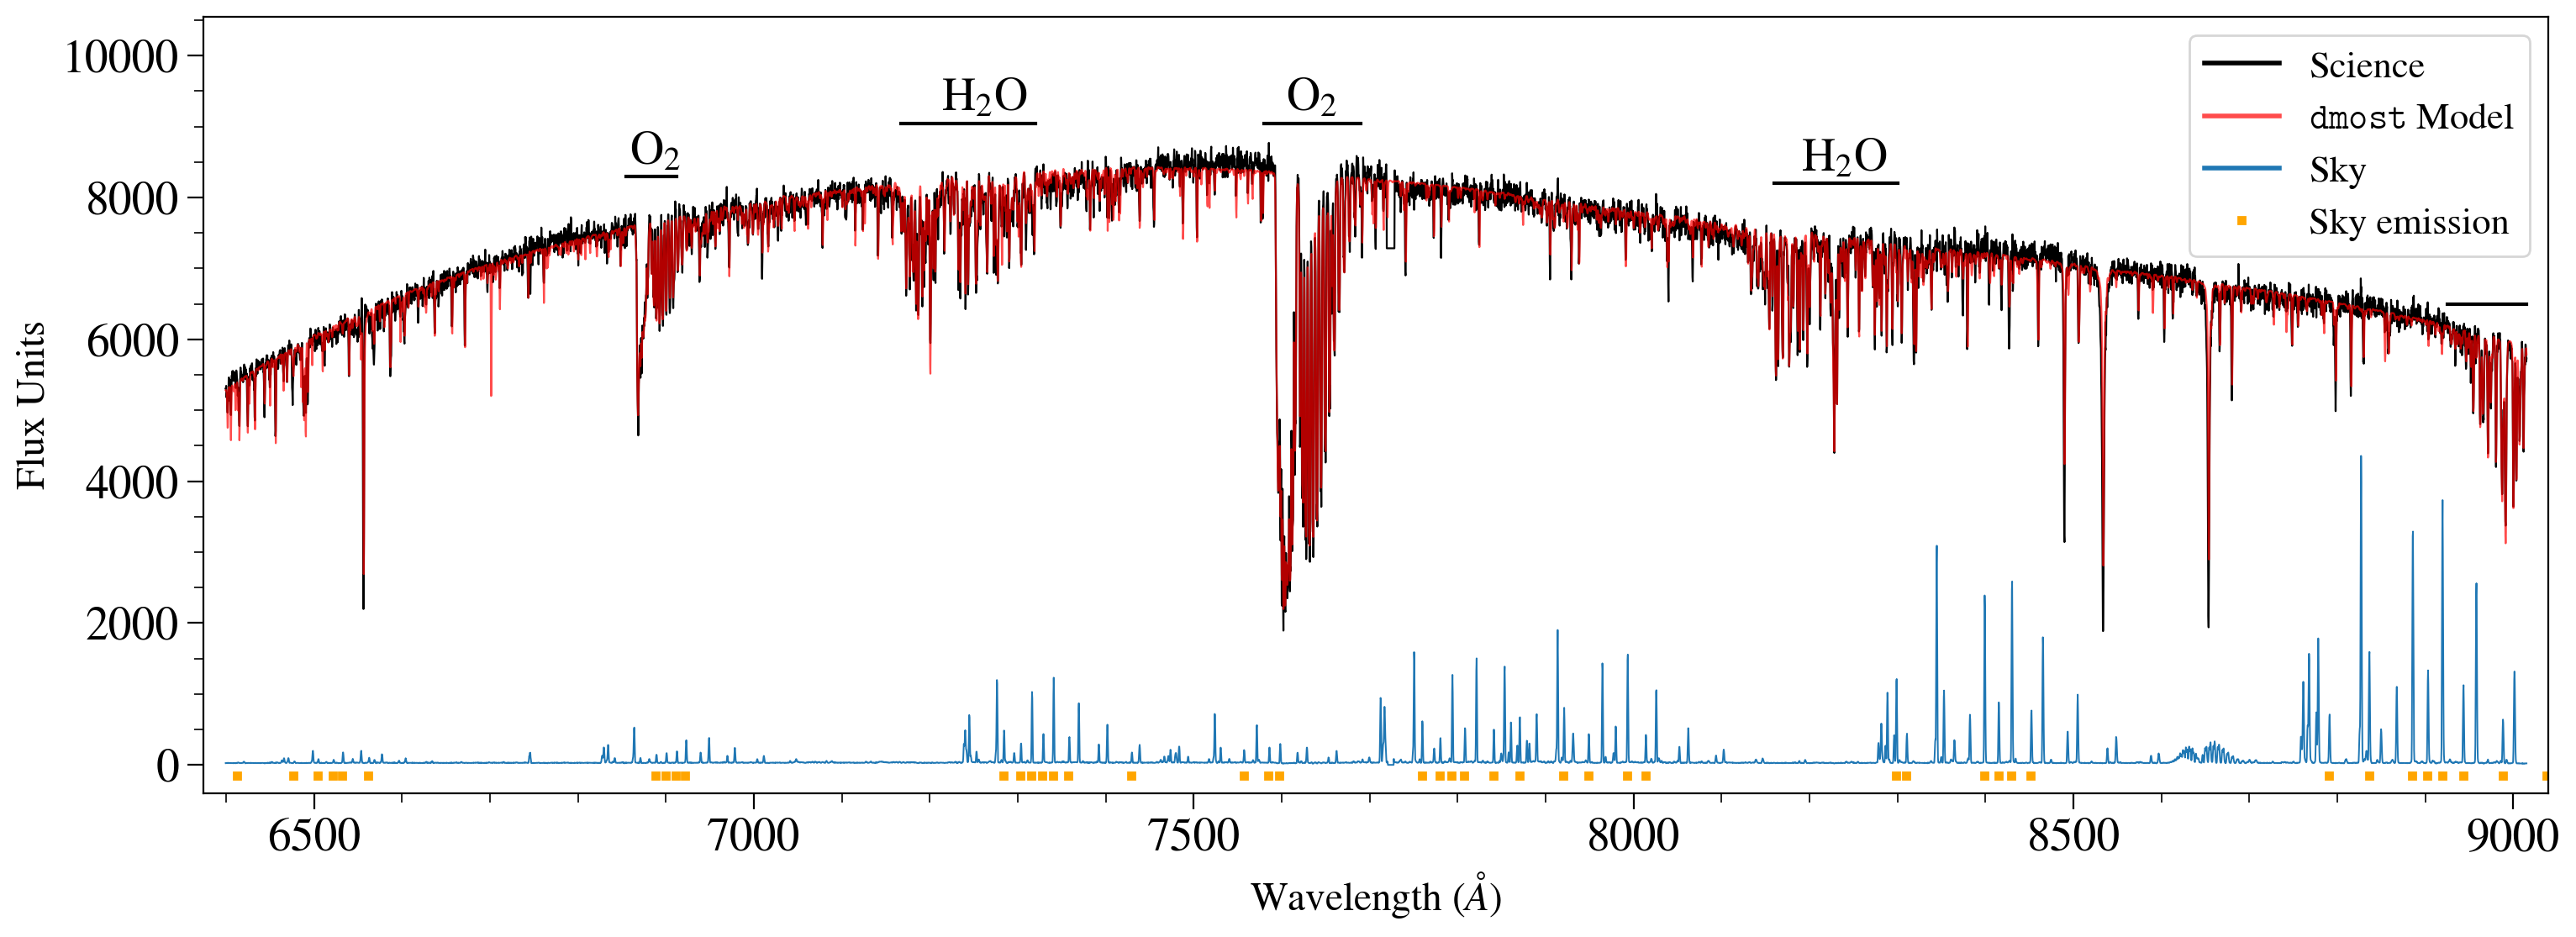

In [9]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_example_spec.pdf')
plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 20})


a=100
plt.plot(data_wave,data_flux-a,'k',label='Science',linewidth=0.8)
plt.plot(data_wave,model-a,'red',label=r'${\tt dmost}$ Model',lw=0.8,alpha=0.7)  


plt.plot(data_wave,0.23*data_sky,label='Sky',linewidth=0.7)
plt.plot(swave-3,-150*np.ones(np.size(sky)),'s',color='orange',label='Sky emission',lw=5,ms=3)
lgnd = plt.legend(fontsize=16,loc='upper right')

lgnd.legendHandles[0].set_linewidth(2)
lgnd.legendHandles[1].set_linewidth(2)
lgnd.legendHandles[2].set_linewidth(2)


plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux Units')

# ADD TELLURIC VALUES
y=1.02*np.max(data_flux)

xmin = np.min(data_wave)
xmax = np.max(data_wave)

plt.xlim(xmin-25,xmax+25)
plt.ylim(-400,y+1500)


bb = [6855,7167,7580,8160,8925]
rr = [6912,7320,7690,8300,9120]
lb=['O$_2$','H$_2$O','O$_2$','H$_2$O','H2O']
ii=0
for a,b,c in zip(bb,rr,lb):
    if a == 9000:
        y=1600
    if (ii < 3) & (ii>0):
        plt.plot([a,b],[y,y],'k')
        plt.text(np.mean(a+b)/2-30,y+175,c)
    if (ii==0):
        yy=y-750
        plt.plot([a,b],[yy,yy],'k')
        plt.text(np.mean(a+b)/2-25,yy+175,c)
    if (ii==3):
        yy=y-850
        plt.plot([a,b],[yy,yy],'k')
        plt.text(np.mean(a+b)/2-40,yy+175,c)
    if (ii==4):
        yy=6500
        bb=np.max(data_wave)
        plt.plot([a,bb],[yy,yy],'k')

    ii=ii+1

pdf.savefig()
pdf.close()